## Init

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

SEED = 42

C:\Users\giorg\Documents\GitHub\miRNA_&_mRNA


In [4]:
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))

In [5]:
print(dataset.shape)
print(dataset.columns)
# print(dataset.head())
print(type(dataset.iloc[0]['days_to_death']))

(760, 1896)
Index(['days_to_death', 'age_at_initial_pathologic_diagnosis',
       'days_to_last_followup', 'Death', 'pathologic_stage_Stage I',
       'pathologic_stage_Stage IA', 'pathologic_stage_Stage IB',
       'pathologic_stage_Stage II', 'pathologic_stage_Stage IIA',
       'pathologic_stage_Stage IIB',
       ...
       'hsa-mir-941-5', 'hsa-mir-942', 'hsa-mir-943', 'hsa-mir-944',
       'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a',
       'hsa-mir-99b'],
      dtype='object', length=1896)
<class 'numpy.float64'>


## Hyper-parameters

In [6]:
num_folds = 20

## Data

In [7]:
unique, count = np.unique(dataset['age_at_initial_pathologic_diagnosis'], return_counts=True)
to_drop = [unique[u] for u in range(len(unique)) if count[u] < 5]
print(to_drop)
print(dataset.shape)

dataset=dataset[~dataset['age_at_initial_pathologic_diagnosis'].isin(to_drop)]
print(dataset.shape)

[np.int64(26), np.int64(27), np.int64(30), np.int64(31), np.int64(32), np.int64(83), np.int64(85), np.int64(86), np.int64(88), np.int64(89)]
(760, 1896)
(739, 1896)


In [8]:
y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
X_cols = [col for col in dataset.columns if col not in y_cols]

custom_dtype = np.dtype([
    ('death', np.bool_),         # O 'bool'
    ('days', np.float64)      # O 'float'
])

y = []
for index,row in dataset[y_cols].iterrows():
    if row['Death'] == 1:
        y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
    elif row['Death'] == 0:
        tuple = (False, row['days_to_last_followup'].item())
        y.append(np.array(tuple, dtype=custom_dtype)) 
y = np.array(y)

X = dataset[X_cols]
# remove columns with zero-variance
# print(X.shape)
X = X.loc[:, X.var() != 0]
# print(X.shape)

## Z-scaling

In [9]:
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# minmax = MinMaxScaler(feature_range=(0,15))

scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# minmaxed_X = pd.DataFrame(minmax.fit_transform(scaled_X), columns = scaled_X.columns)

## Data splitting

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify=X['age_at_initial_pathologic_diagnosis'])

K-fold

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
#kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Linear MLP

### 3-layer model

In [12]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score

class MiRNANet_3(nn.Module):
    def __init__(self, input_dim, output_dim, dropout, start_lr=0.001, lr_decay=0.3, patience=15):
        super(MiRNANet_3, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(32, output_dim),
            #nn.Softmax(-1)
        )
        self.lr_decay = lr_decay
        self.patience = patience
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=start_lr)
        self.criterion = nn.L1Loss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=self.lr_decay,        # dimezza il learning rate
            patience=self.patience        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)   
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            total_train_acc = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
                total_train_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
            
            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_acc = total_train_acc / len(train_loader)
            
            self.scheduler.step(avg_train_loss)

            train_accs.append(avg_train_acc)

            self.model.eval()
            total_val_loss = 0
            total_val_acc = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                    total_val_loss += loss.item()
                    total_val_acc += accuracy_score(np.argmax(outputs.detach().numpy(), axis=1), np.argmax(y_batch, axis=1))
                preds = np.vstack(preds)
                trues = np.vstack(trues)
            avg_val_loss = total_val_loss / len(test_loader)
            avg_val_acc = total_val_acc / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            val_accs.append(avg_val_acc)

            print(f"Epoch {epoch+1:03d}:\nTrain Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}\nTrain Acc: {avg_train_acc:.4f} | Val Acc: {avg_val_acc:.4f}")
            mae = mean_absolute_error(trues, preds)
            print(f"Test MAE: {mae:.2f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses,
            'train_accs': train_accs,
            'val_accs':val_accs,
            'preds':preds,
            'trues':trues
        }

        return model_res

### 5-layer model

In [ ]:
class MiRNANet_5(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):#, start_lr = 0.001):
        super(MiRNANet_5, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_dim)  # <--- ultimo layer lineare
        )
        self.optimizer = torch.optim.Adam(self.model.parameters())#, lr=start_lr)
        self.criterion = nn.MSELoss()
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
            factor=0.6,        # dimezza il learning rate
            patience=15        # aspetta 10 epoche senza miglioramenti
        )
    def forward(self, x):
        return self.model(x)
    
    def loop(self, train_loader, test_loader, epochs=100):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            self.model.train()
            total_train_loss = 0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                # print(outputs)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()
            
            avg_train_loss = total_train_loss / len(train_loader)
            self.scheduler.step(avg_train_loss)

            self.model.eval()
            total_val_loss = 0
            with torch.no_grad():
                preds = []
                trues = []
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    preds.append(outputs.numpy())
                    trues.append(y_batch.numpy())
                preds = np.vstack(preds)
                trues = np.vstack(trues)
                total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(test_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        model_res = {
            'params':self.model.parameters(),
            'train_losses':train_losses,
            'eval_losses': val_losses
        }

        return model_res

### Grid search for best parameters

In [13]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import LRScheduler
from sklearn.metrics import make_scorer

import torch
torch.manual_seed(0)


class MiRNANet_3_grid(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(MiRNANet_3_grid, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.BatchNorm1d(64),
            nn.LayerNorm(64),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_dim),
        )

    def forward(self, x):
        return self.model(x)#.squeeze(-1)

#y_fixed = np.array([(row['death'], row['days']) for row in y], dtype=[('death', np.bool_), ('days', np.float64)])
y_fixed = np.array([row['days'] for row in y_train], dtype=np.float32)
y_mlp = torch.tensor([row for row in y_fixed], dtype=torch.float32)
X_mlp = torch.tensor(X_train.values, dtype=torch.float32)

# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet_3_grid, # MiRNANet_3,
    module__input_dim=X_mlp.shape[1], #X_train_mlp.shape[1],
    module__output_dim=1, #y_train_mlp.shape[1],
    max_epochs=60,
    lr=1e-2,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-6,
    #optimizer__lr=0.001,
    criterion=nn.MSELoss(),# CoxPHLoss(), # nn.SmoothL1Loss(beta=1.0),# CoxPHLoss(),# nn.MSELoss(),  #nn.L1Loss(),
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=15, 
             monitor='valid_loss',
             min_lr=1e-6
         ))
    ],
)

params = {
    ##'module__hidden1': [128, 256, 512],
    ##'module__hidden2': [64, 128, 256],
    'module__dropout': [0.2, 0.3],#, 0.5],
    #'module__start_lr': [0.1, 1e-3, 5e-4],
    #'module__lr_decay': [0.3, 0.4],
    ##'optimizer__weight_decay': [0, 1e-5, 1e-4],
   # #'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    ##'callbacks__lr_scheduler__patience': [15, 10, 5],
    'lr': [1e-1, 1e-3]#, 1e-2]#, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=kfold,  # cross-validation folds 
                  #scoring='neg_mean_squared_error', 
                  #scoring=cindex,
                  verbose=1,
                  n_jobs=1)

gs.fit(X_mlp, y_mlp.unsqueeze(1))

best_model_mse = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)
print("Best score :", gs.best_score_)

Fitting 20 folds for each of 2 candidates, totalling 40 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1377067.8438  1150482.2926  0.1000  0.0732
      2  1050330.3304  1059356.9591  0.1000  0.0753
      3   773742.3170  1129277.0553  0.1000  0.0621
      4   510513.8482  1086274.8457  0.1000  0.0710
      5   293656.8521  1045737.2699  0.1000  0.0639
      6   273683.5251  1180564.8894  0.1000  0.0626
      7   242676.3147  1235551.1250  0.1000  0.0701
      8   219043.7232  1215952.8119  0.1000  0.0597
      9   157159.6791  1266590.4580  0.1000  0.0690
     10   242511.6897  1325317.7611  0.1000  0.0596
     11   252737.9007  1440414.7013  0.1000  0.0578
     12   269439.6423  1935944.5619  0.1000  0.0610
     13   218198.4180  1330777.0653  0.1000  0.0603
     14   166291.6281  1293094.2644  0.1000  0.0584
     15   236120.7528  1627464.8142  0.1000  0.0608
     16   176006.4626  1993114.5044  0.1000  0.0592
   

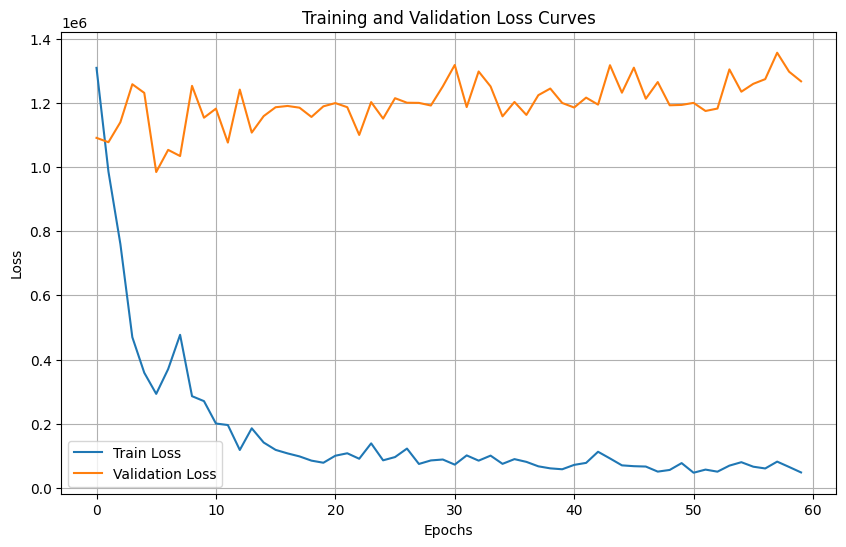

In [14]:
# Plot train and val loss curves

plt.figure(figsize=(10, 6))
plt.plot(best_model_mse.history[:, 'train_loss'], label='Train Loss')
plt.plot(best_model_mse.history[:, 'valid_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()

#### Test scoring C Index

In [17]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import LRScheduler
from sklearn.metrics import make_scorer
from lifelines.utils import concordance_index

import torch
torch.manual_seed(0)

class MiRNANet_3_grid(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(MiRNANet_3_grid, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            #nn.BatchNorm1d(64),
            nn.LayerNorm(64),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_dim),
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

y_fixed = np.array([row['days'] for row in y_train], dtype=np.float32)
X_mlp = X_train.values.astype(np.float32)
y_mlp = y_fixed.astype(np.float32)

def cindex_scorer(y_true, y_pred):
    return concordance_index(y_true, -y_pred.ravel())

cindex = make_scorer(cindex_scorer, greater_is_better=True)


# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet_3_grid, # MiRNANet_3,
    module__input_dim=X_mlp.shape[1], #X_train_mlp.shape[1],
    module__output_dim=1, #y_train_mlp.shape[1],
    max_epochs=30,
    lr=1e-2,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-6,
    #optimizer__lr=0.001,
    criterion=nn.MSELoss(), #nn.MSELoss(),# CoxPHLoss(), # nn.SmoothL1Loss(beta=beta_value), #nn.L1Loss(),
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=15, 
             monitor='valid_loss',
             min_lr=1e-6
         ))
    ],
)
params = {
    ##'module__hidden1': [128, 256, 512],
    ##'module__hidden2': [64, 128, 256],
    'module__dropout': [0.2],#, 0.3],#, 0.5],
    #'module__start_lr': [0.1], #[0.1, 1e-3, 5e-4],
    #'module__lr_decay': [0.3, 0.4],
    ##'optimizer__weight_decay': [0, 1e-5, 1e-4],
   # #'callbacks__lr_scheduler__factor': [0.8, 0.6, 0.4],
    ##'callbacks__lr_scheduler__patience': [15, 10, 5],
    'lr': [1e-1, 1e-3]#, 1e-2]#, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=kfold,  # cross-validation folds
                  scoring=cindex,
                  verbose=1,
                  n_jobs=1)

y_mlp = y_mlp.reshape(-1)
gs.fit(X_mlp, y_mlp)

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)
print("Best C-index:", gs.best_score_)

Fitting 20 folds for each of 2 candidates, totalling 40 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1  1377067.8438  1150482.2926  0.1000  0.0457
      2  1050330.3304  1059356.9591  0.1000  0.0853
      3   773742.3170  1129277.0553  0.1000  0.0747
      4   510513.8482  1086274.8457  0.1000  0.0702
      5   293656.8521  1045737.2699  0.1000  0.0520
      6   273683.5251  1180564.8894  0.1000  0.0552
      7   242676.3147  1235551.1250  0.1000  0.0569
      8   219043.7232  1215952.8119  0.1000  0.0539
      9   157159.6791  1266590.4580  0.1000  0.0556
     10   242511.6897  1325317.7611  0.1000  0.0626
     11   252737.9007  1440414.7013  0.1000  0.0648
     12   269439.6423  1935944.5619  0.1000  0.0668
     13   218198.4180  1330777.0653  0.1000  0.0547
     14   166291.6281  1293094.2644  0.1000  0.0645
     15   236120.7528  1627464.8142  0.1000  0.0647
     16   176006.4626  1993114.5044  0.1000  0.0607
   

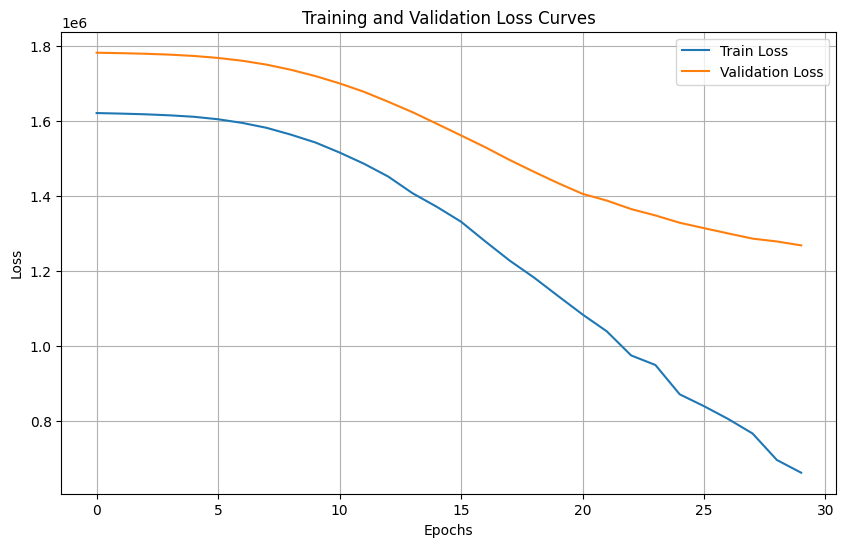

In [18]:
# Plot train and val loss curves

plt.figure(figsize=(10, 6))
plt.plot(best_model.history[:, 'train_loss'], label='Train Loss')
plt.plot(best_model.history[:, 'valid_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()

In [19]:
y_test_fixed = np.array([row['days'] for row in y_test], dtype=np.float32)
y_test_mlp = torch.tensor([row for row in y_test_fixed], dtype=torch.float32)
X_test_mlp = torch.tensor(X_test.values, dtype=torch.float32)

preds = best_model.predict(X_test_mlp)
mae = mean_absolute_error(y_test_mlp, preds)
r2 = r2_score(y_test_mlp, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

Test MAE: 603.23 | R2: -0.24


test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- 1. Definizione della MLP ---
class DeepSurvMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32, 16], dropout=0.3):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(dims[-1], 1))  # output scalare f_theta(X)
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# --- 2. Loss function: negative partial log-likelihood di Cox ---
def cox_partial_log_likelihood(pred, time, event):
    """
    pred: f_theta(X), shape [N, 1]
    time: tempi di follow-up, shape [N]
    event: indicatori di evento (1=evento, 0=censurato), shape [N]
    """
    pred = pred.reshape(-1)
    order = torch.argsort(time, descending=True)
    pred = pred[order]
    event = event[order]

    risk_sum = torch.logcumsumexp(pred, dim=0)
    loss = -torch.sum(pred[event==1] - risk_sum[event==1])
    return loss / event.sum()  # media sul numero di eventi

# --- 3. Simulazione dati fittizi ---
#N, D = 100, 5  # 100 soggetti, 5 covariate
torch.manual_seed(0)
#X = torch.randn(N, D)
#time = torch.rand(N) * 10
#event = torch.randint(0, 2, (N,))
X = X_mlp
time = torch.tensor([row['days'] for row in y], dtype=torch.float32)
event = torch.tensor([row['death'] for row in y], dtype=torch.float32)


# --- 4. Creazione modello e ottimizzatore ---
model = DeepSurvMLP(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# --- 5. Training loop semplice ---
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X)
    loss = cox_partial_log_likelihood(pred, time, event)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# --- 6. Predizione dei rischi relativi ---
model.eval()
with torch.no_grad():
    risk_scores = model(X)
    hazard_ratios = torch.exp(risk_scores)  # hazard relativo rispetto al baseline
    print("Hazard ratios:", hazard_ratios[:5].reshape(-1))
